# Evaluate forecasts

In this notebook, we will compute all the scores for the baseline models and create the figures for the paper. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
res = '5.625'
DATADIR = f'/data/weather-benchmark/{res}deg/'
PREDDIR = '/data/weather-benchmark/predictions/'

## Load data

First let's load all the prediction files from the previous notebooks.

In [8]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid_data = xr.merge([z500_valid, t850_valid])

In [6]:
persistence = xr.open_dataset(f'{PREDDIR}persistence_{res}.nc')
climatology = xr.open_dataset(f'{PREDDIR}climatology_{res}.nc')
weekly_climatology = xr.open_dataset(f'{PREDDIR}weekly_climatology_{res}.nc')

In [7]:
lr_3d = xr.open_dataset(f'{PREDDIR}fc_lr_3d.nc')
lr_5d = xr.open_dataset(f'{PREDDIR}fc_lr_5d.nc')
lr_6h_iter = xr.open_dataset(f'{PREDDIR}fc_lr_6h_iter.nc')

In [8]:
cnn_3d = xr.open_dataset(f'{PREDDIR}fccnn_3d.nc')
cnn_5d = xr.open_dataset(f'{PREDDIR}fccnn_5d.nc')
cnn_6h_iter = xr.open_dataset(f'{PREDDIR}fccnn_6h_iter.nc')

In [9]:
# See next section on how to compute these from the raw data.
tigge = xr.open_dataset(f'{PREDDIR}/tigge_{res}deg.nc')
# t21 = xr.open_dataset(f'{PREDDIR}/t21_5.625deg.nc')
# t42 = xr.open_dataset(f'{PREDDIR}/t42_5.625deg.nc')

## TIGGE and IFT T21 data

For these we need to do some preprocessing to get the data into the same format as our ERA5 files.

You can skip this step if you alread managed to load the data above. This takes a while.

In [43]:
# Convert from geopotential height to geopotential
tigge_raw_z = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/z*.nc').squeeze()
tigge_raw_t = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/t*.nc').squeeze()

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
htt

In [44]:
tigge_raw = xr.merge([tigge_raw_z.drop('lev'), tigge_raw_t.drop('lev')])

In [45]:
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 30660)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>

In [46]:
# Convert from geopotential height to geopotential
tigge_raw['z'] = tigge_raw.gh * 9.807
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 30660)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    z        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>

In [48]:
tigge_raw = tigge_raw.drop('gh')

In [8]:
t42_raw = xr.open_dataset(f'/media/rasp/Elements/weather-benchmark/IFS_T41/output_42_pl_5.625.nc')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [54]:
t42_raw_new = xr.opendataset(f'/media/rasp/Elements/weather-benchmark/IFS_T41/output_42_pl_5.625_new.nc')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [68]:
t42_hr = xr.open_dataset('/media/rasp/Elements/weather-benchmark/IFS_T41/output_42_pl_2.8125.nc')

In [72]:
my5 = xr.open_dataset('/media/rasp/Elements/weather-benchmark/IFS_T41/my5.625.nc')

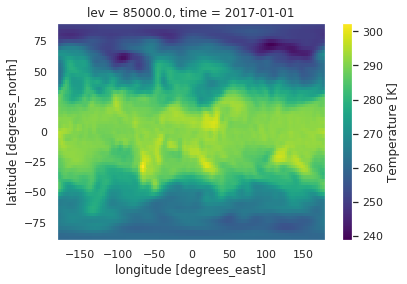

In [70]:
t42_hr.t.isel(time=0).sel(lev=8.5e4).plot()

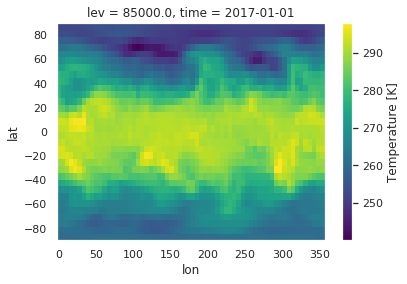

In [73]:
my5.t.isel(time=0).sel(lev=8.5e4).plot()

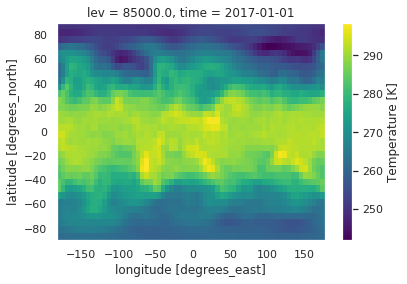

In [74]:
t42_orig.t.isel(time=0).sel(lev=8.5e4).plot()

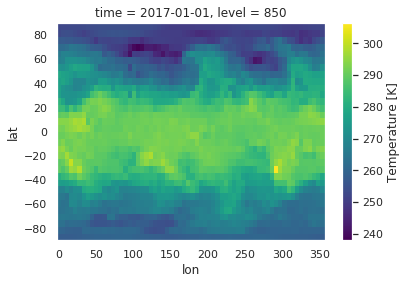

In [71]:
valid_data.t.isel(time=0).plot()

In [9]:
t42_orig = t42_raw.copy()

In [10]:
t42_raw = t42_orig.copy()

In [11]:
t42_raw

<xarray.Dataset>
Dimensions:  (lat: 32, lev: 4, lon: 64, time: 522)
Coordinates:
  * lon      (lon) float64 -180.0 -174.4 -168.8 -163.1 ... 163.1 168.8 174.4
  * lat      (lat) float64 87.19 81.56 75.94 70.31 ... -75.94 -81.56 -87.19
  * lev      (lev) float64 1e+05 8.5e+04 5e+04 2e+04
  * time     (time) datetime64[ns] 2017-01-01 2017-01-01T06:00:00 ... 2017-05-07
Data variables:
    z        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
    t        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
    r        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
    u        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
    v        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.4
    h

In [12]:
t42_raw['lat'] = -tigge_raw_z.lat
t42_raw = t42_raw.roll(lon=32)
t42_raw['lon'] = tigge_raw_z.lon

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


In [55]:
t42_raw_new['lat'] = -tigge_raw_z.lat
t42_raw_new = t42_raw_new.roll(lon=32)
t42_raw_new['lon'] = tigge_raw_z.lon

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


In [13]:
t42_raw.lat

<xarray.DataArray 'lat' (lat: 32)>
array([ 87.1875,  81.5625,  75.9375,  70.3125,  64.6875,  59.0625,  53.4375,
        47.8125,  42.1875,  36.5625,  30.9375,  25.3125,  19.6875,  14.0625,
         8.4375,   2.8125,  -2.8125,  -8.4375, -14.0625, -19.6875, -25.3125,
       -30.9375, -36.5625, -42.1875, -47.8125, -53.4375, -59.0625, -64.6875,
       -70.3125, -75.9375, -81.5625, -87.1875])
Coordinates:
  * lat      (lat) float64 87.19 81.56 75.94 70.31 ... -75.94 -81.56 -87.19

In [49]:
def convert_time(ds, nlead_time):
    """Converts to lead_time format"""
    init_times = ds.time[::nlead_time]
    lead_times = xr.DataArray(
        np.arange(0, 6*nlead_time, 6), dims=['lead_time'], coords={'lead_time': np.arange(0, 6*nlead_time, 6)})
    
    coords = dict(ds.coords); coords.pop('time')
    coords['time'] = init_times; coords['lead_time'] = lead_times
    ds_by_lead = xr.merge([xr.DataArray(
        ds[var].values.reshape((len(init_times), len(lead_times)) + ds[var].shape[1:]),
        dims = ('time', 'lead_time') + ds[var].dims[1:],
        coords = coords,
        name=var
    ) for var in ds])
    return ds_by_lead

In [50]:
tigge = convert_time(tigge_raw, 21)

In [51]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lon: 64, time: 1460)
Coordinates:
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T12:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    t          (time, lead_time, lat, lon) float32 257.98013 ... 252.24873
    z          (time, lead_time, lat, lon) float32 50928.676 ... 49982.945

In [46]:
tigge_t

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lev: 2, lon: 64, time: 608)
Coordinates:
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lev        (lev) float64 5e+04 8.5e+04
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-10-31T12:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    t          (time, lead_time, lev, lat, lon) float32 247.54436 ... 260.41785

In [78]:
tigge = xr.merge([tigge_z.drop('lev'), tigge_t.sel(lev=8.5e4).squeeze().drop('lev')])

In [79]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lon: 64, time: 608)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-10-31T12:00:00
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    gh         (time, lead_time, lat, lon) float32 5205.32 5209.601 ... nan nan
    z          (time, lead_time, lat, lon) float32 51048.574 51090.56 ... nan
    t          (time, lead_time, lat, lon) float32 nan nan ... 260.41785

In [17]:
t42 = convert_time(xr.Dataset({'z': t42_raw.z.sel(lev=5e4), 't': t42_raw.t.sel(lev=8.5e4)}, compat='override'), 29)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The `compat` argument to Dataset is deprecated and will be removed in 0.14.Instead, use `merge` to control how variables are combined
  """Entry point for launching an IPython kernel.


In [56]:
t42_new = convert_time(xr.Dataset({'z': t42_raw_new.z.sel(lev=5e4), 't': t42_raw_new.t.sel(lev=8.5e4)}, compat='override'), 29)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The `compat` argument to Dataset is deprecated and will be removed in 0.14.Instead, use `merge` to control how variables are combined
  """Entry point for launching an IPython kernel.


In [52]:
# Save for later usage
tigge.to_netcdf(f'{PREDDIR}/tigge_5.625deg.nc2')

In [54]:
PREDDIR

'/data/weather-benchmark/predictions/'

In [28]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lon: 64, time: 608)
Coordinates:
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    lev        float64 5e+04
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-10-31T12:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    gh         (time, lead_time, lat, lon) float32 5193.094 ... 5110.644
    t          (time, lead_time, lat, lon) float32 241.34908 ... 234.8365
    z          (time, lead_time, lat, lon) float32 50928.676 ... 50120.086

In [75]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lev: 2, lon: 64, time: 608)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-10-31T12:00:00
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lev        (lev) float64 5e+04 8.5e+04
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    gh         (time, lead_time, lat, lon) float32 ...
    z          (time, lead_time, lat, lon) float32 ...
    t          (time, lead_time, lev, lat, lon) float32 ...

In [ ]:
t21.to_netcdf(f'{PREDDIR}/t21_5.625deg.nc')

In [20]:
t42.to_netcdf(f'{PREDDIR}/t42_5.625deg.nc')

## Compute RMSE

In [11]:
tigge_rmse = evaluate_iterative_forecast(tigge, valid_data).load()
# t21_rmse = evaluate_iterative_forecast(t21, valid_data).load()
# t42_rmse = evaluate_iterative_forecast(t42, valid_data).load()

In [12]:
rmse_persistence = evaluate_iterative_forecast(persistence, valid_data).load()
rmse_climatology = compute_weighted_rmse(climatology, valid_data).load()
rmse_weekly_climatology = compute_weighted_rmse(weekly_climatology, valid_data).load()

In [13]:
rmse_lr_6h_iter =evaluate_iterative_forecast(lr_6h_iter, valid_data).load()
rmse_lr_3d = compute_weighted_rmse(lr_3d, valid_data).load()
rmse_lr_5d = compute_weighted_rmse(lr_5d, valid_data).load()

In [14]:
rmse_cnn_6h_iter = evaluate_iterative_forecast(cnn_6h_iter, valid_data).load()
rmse_cnn_3d = compute_weighted_rmse(cnn_3d, valid_data).load()
rmse_cnn_5d = compute_weighted_rmse(cnn_5d, valid_data).load()

In [15]:
rmse = xr.merge(
    [r.rename({'z_rmse': f'z_{n}', 't_rmse': f't_{n}'}) for r, n in zip(
        [rmse_persistence, rmse_climatology, rmse_weekly_climatology, 
         rmse_lr_6h_iter, rmse_lr_3d, rmse_lr_5d,
         rmse_cnn_6h_iter, rmse_cnn_3d, rmse_cnn_5d,
         tigge_rmse#, t42_rmse
        ],
        ['persistence', 'climatology', 'weekly_climatology',
         'lr_6h_iter', 'lr_3d', 'lr_5d',
         'cnn_6h_iter', 'cnn_3d', 'cnn_5d',
         'tigge'#, 't42'
        ]
    )],
)

In [32]:
rmse.to_netcdf(f'{PREDDIR}rmse_{res}.nc')

## Values for table

In [33]:
for var in rmse:
    if 'lead_time' in rmse[var].coords:
        print(var, rmse[var].sel(lead_time=[3*24, 5*24]).values)

z_persistence [ 935.90988883 1033.16034145]
t_persistence [4.2913616  4.55460269]
z_lr_6h_iter [718.55974983 811.78800565]
t_lr_6h_iter [3.16938105 3.48315969]
z_cnn_6h_iter [1114.15922913 1558.7653464 ]
t_cnn_6h_iter [4.4798912  9.69299709]
t_tigge [1.35549653 2.03162561]
z_tigge [153.08307404 334.09909614]


In [34]:
for var in rmse:
    if 'lead_time' not in rmse[var].coords:
        print(var, rmse[var].values)

z_climatology 1075.3035281525836
t_climatology 5.5115010536157465
z_weekly_climatology 815.6778381918858
t_weekly_climatology 3.5019970713382653
z_lr_3d 713.781586289599
t_lr_3d 3.1846160636176273
z_lr_5d 813.5394907886767
t_lr_5d 3.517879424149844
z_cnn_3d 626.3972448687404
t_cnn_3d 2.8696212431662476
z_cnn_5d 756.6651261925969
t_cnn_5d 3.3700776866733544


## Plot

In [49]:
def create_plot(var, save_fn=None, ax=None, legend=False):
    # Color settings
    c_lri = 'seagreen'
    c_lrd = 'seagreen'
    c_cnni = 'firebrick'
    c_cnnd = 'firebrick'
    c_tigge = 'navy'
    c_t21 = 'orange'
    c_persistence = '0.2'
    c_climatology = '0.5'
    c_weekly_climatology = '0.7'
    
    if ax is None: fig, ax = plt.subplots(1, 1, figsize=(5, 4)) 
    rmse[var+'_persistence'].plot(c=c_persistence, label='Persistence', lw=2, ax=ax)
    ax.axhline(rmse[var+'_climatology'], ls='--', c=c_climatology, label='Climatology', lw=2)
    ax.axhline(rmse[var+'_weekly_climatology'], ls='--', c=c_weekly_climatology, label='Weekly clim.', lw=2)
    rmse[var+'_tigge'].plot(c=c_tigge, label='Operational', lw=2, ax=ax)
#     rmse[var+'_t42'].plot(c=c_t21, label='IFS T42', lw=2, ax=ax)
#     t42_rmse_new[var+'_rmse'].plot(c=c_t21, label='IFS T42 new', lw=2, ax=ax, ls='--')
    rmse[var+'_lr_6h_iter'].plot(c=c_lri, label='LR (iterative)', lw=2, ax=ax)
    ax.scatter([3*24], [rmse[var+'_lr_3d']], c=c_lrd, s=100, label='LR (direct)', lw=2, edgecolors='k', zorder=10)
    ax.scatter([5*24], [rmse[var+'_lr_5d']], c=c_lrd, s=100, lw=2, edgecolors='k', zorder=10)
    rmse[var+'_cnn_6h_iter'].plot(c=c_cnni, label='CNN (iterative)', lw=2, ax=ax)
    ax.scatter([3*24], [rmse[var+'_cnn_3d']], c=c_cnnd, s=100, label='CNN (direct)', lw=2, edgecolors='k', zorder=10)
    ax.scatter([5*24], [rmse[var+'_cnn_5d']], c=c_cnnd, s=100, lw=2, edgecolors='k', zorder=10)
    
    
    if var == 'z':
        ax.set_ylim(0, 1200)
        ax.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
        ax.set_title('a) Z500')
    elif var == 't':
        ax.set_ylim(0, 6)
        ax.set_ylabel(r'T850 RMSE [K]')
        ax.set_title('b) T850')
        
    if legend: ax.legend(loc=2, framealpha=1)
    ax.set_xlim(0, 122)
    ax.set_xticks(range(0, 121, 24))
    ax.set_xticklabels(range(6))
    ax.set_xlabel('Forecast time [days]')
    
    if not save_fn is None: 
        plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
        fig.savefig(save_fn)

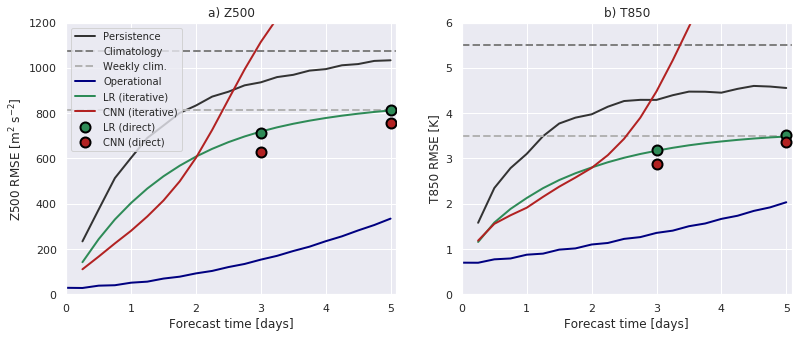

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
create_plot('z', ax=ax1)
create_plot('t', ax=ax2)
ax1.legend(loc=2, ncol=1, fontsize=10)
fig.savefig('../figures/rmse.pdf', bbox_inches='tight')

## Other figures for paper

In [5]:
sns.set_style('dark')

NameError: name 'cnn_6h_iter' is not defined

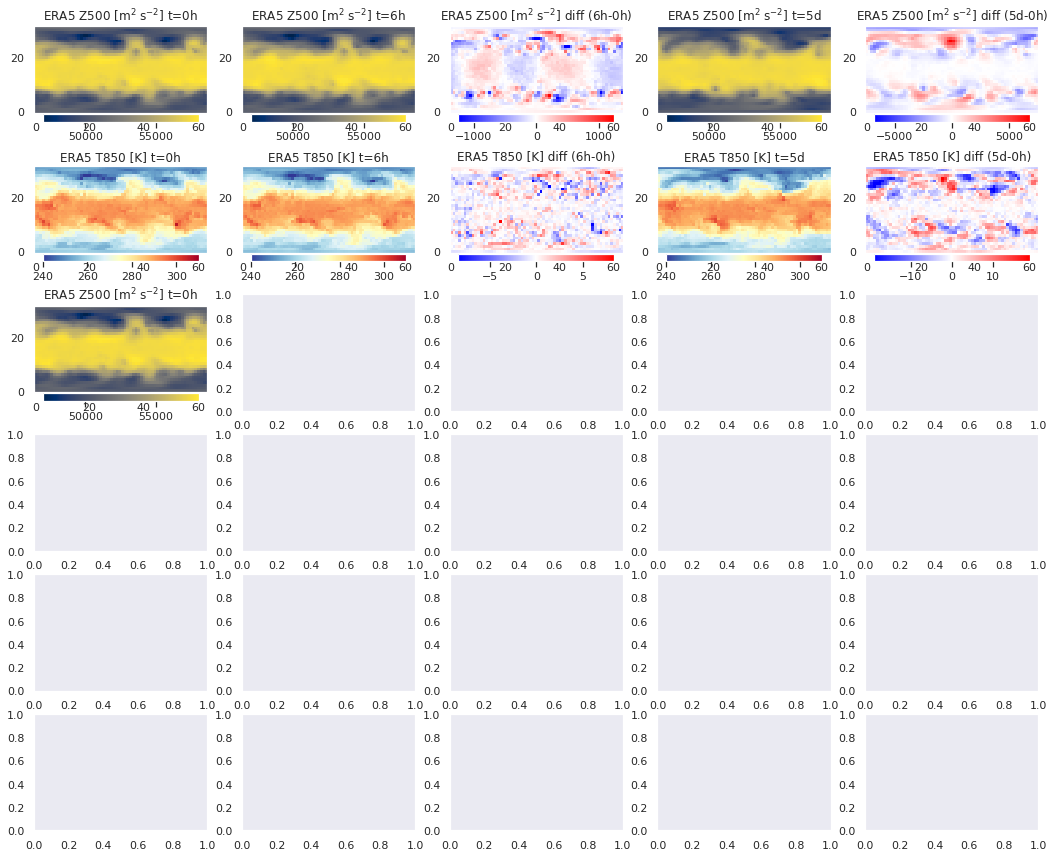

In [9]:
cmap_z = 'cividis'
cmap_t = 'RdYlBu_r'
cmap_diff = 'bwr'
cmap_error = 'BrBG'

def imcol(ax, data, title='', **kwargs):
    if not 'vmin' in kwargs.keys():
        mx = np.abs(data.max().values)
        kwargs['vmin'] = -mx; kwargs['vmax'] = mx
    I = ax.imshow(data, **kwargs)
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
    ax.set_title(title)

fig, axs = plt.subplots(6, 5, figsize=(18, 15))
# True
for iax, var, cmap, r, t in zip(
    [0, 1], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], valid_data[var].isel(time=6), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=6h')
    imcol(axs[iax,2],
        valid_data[var].isel(time=6)-valid_data[var].isel(time=0), origin='lower', cmap=cmap_diff, 
        title=f'ERA5 {t} diff (6h-0h)')
    imcol(axs[iax,3], valid_data[var].isel(time=5*24), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=5d')
    imcol(axs[iax,4], 
        valid_data[var].isel(time=5*24)-valid_data[var].isel(time=0), origin='lower', cmap=cmap_diff, 
        title=f'ERA5 {t} diff (5d-0h)')

# CNN
for iax, var, cmap, r, t in zip(
    [2, 3], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], cnn_6h_iter[var].isel(time=0).sel(lead_time=6), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNi {t} t=6h')
    imcol(axs[iax,2], 
        cnn_6h_iter[var].isel(time=0).sel(lead_time=6)-valid_data[var].isel(time=6), origin='lower', cmap=cmap_error,
        title=f'Error CNNi - ERA5 {t} t=6h')
    imcol(axs[iax,3], cnn_5d[var].isel(time=0), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNd {t} t=5d')
    imcol(axs[iax,4], 
        cnn_5d[var].isel(time=0) - valid_data[var].isel(time=5*24), origin='lower', cmap=cmap_error,
        title=f'Error CNNd - ERA5 {t} t=5d')

# IFS
for iax, var, cmap, r, t in zip(
    [4, 5], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], tigge[var].isel(time=0).sel(lead_time=0), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], tigge[var].isel(time=0).sel(lead_time=6), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'IFS {t} t=6h')
    imcol(axs[iax,2], 
        tigge[var].isel(time=0).sel(lead_time=6)-valid_data[var].isel(time=6), origin='lower', cmap=cmap_error,
          title=f'Error IFS - ERA5 {t} t=6h')
    imcol(axs[iax,3], tigge[var].isel(time=0).sel(lead_time=5*24), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'IFS {t} t=5d')
    imcol(axs[iax,4], 
        tigge[var].isel(time=0).sel(lead_time=5*24) - valid_data[var].isel(time=5*24), origin='lower', cmap=cmap_error,
        title=f'Error IFS - ERA5 {t} t=5d')
for ax in axs.flat:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(pad=0)
plt.savefig('../figures/examples.pdf', bbox_inches='tight')

In [30]:
valid_data

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
    level    int32 850
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [45]:
def plot_map(data, fn, cbar, vmin, vmax):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(data, cmap=cbar, vmin=vmin, vmax=vmax)
    ax.set_xticks([]); ax.set_yticks([]);
    plt.subplots_adjust(0, 0, 1, 1)
    fig.savefig(fn, bbox_inches=0, transparent='true')

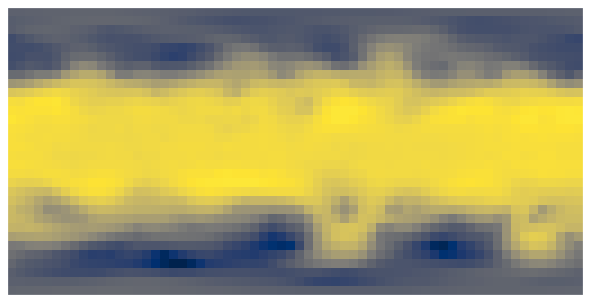

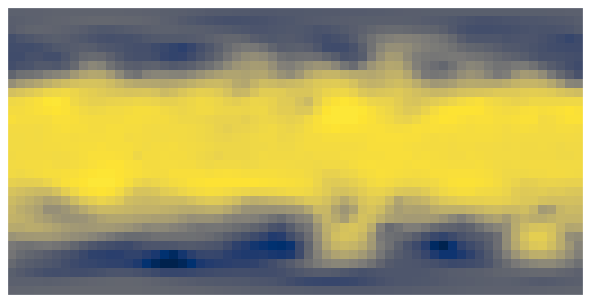

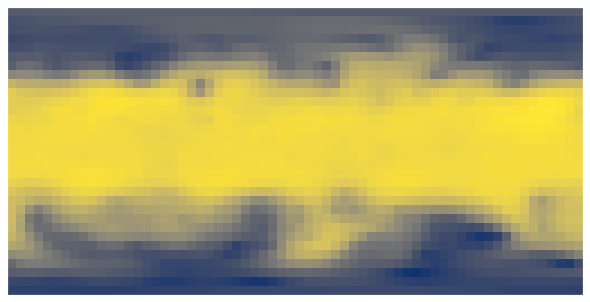

In [52]:
plot_map(valid_data.z.isel(time=0), '../figures/z_0.pdf', 'cividis', 47000, 58000)
plot_map(valid_data.z.isel(time=6), '../figures/z_6h.pdf', 'cividis', 47000, 58000)
plot_map(valid_data.z.isel(time=5*24), '../figures/z_5d.pdf', 'cividis', 47000, 58000)

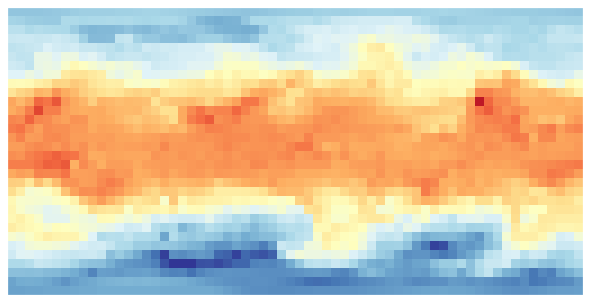

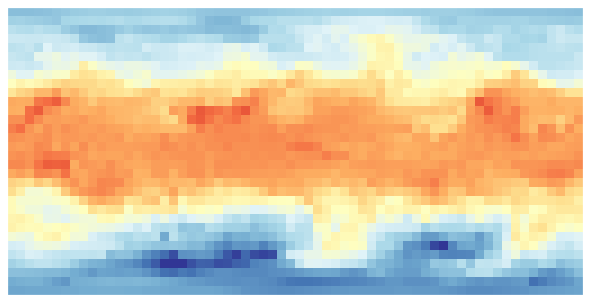

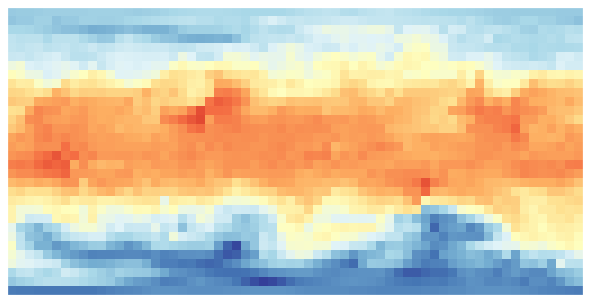

In [53]:
plot_map(valid_data.t.isel(time=0), '../figures/t_0.pdf', 'RdYlBu_r', 240, 310)
plot_map(valid_data.t.isel(time=6), '../figures/t_6h.pdf', 'RdYlBu_r', 240, 310)
plot_map(valid_data.t.isel(time=5*24), '../figures/t_5d.pdf', 'RdYlBu_r', 240, 310)

# Same for higher resolutions

Let's now see how the number change if we do the same for higher resolutions.

In [5]:
res = '2.8125'
DATADIR = f'/media/rasp/Elements/weather-benchmark/{res}deg/'
PREDDIR = '/data/weather-benchmark/predictions/'

In [6]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature', 't')
valid_data = xr.merge([z500_valid, t850_valid])

In [7]:
persistence = xr.open_dataset(f'{PREDDIR}persistence_{res}.nc')
climatology = xr.open_dataset(f'{PREDDIR}climatology_{res}.nc')
weekly_climatology = xr.open_dataset(f'{PREDDIR}weekly_climatology_{res}.nc')

In [9]:
# Convert from geopotential height to geopotential
tigge_raw_z = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/z*.nc').squeeze()
tigge_raw_t = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/t*.nc').squeeze()

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
htt

In [10]:
tigge_raw = xr.merge([tigge_raw_z.drop('lev'), tigge_raw_t.drop('lev')])

In [11]:
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 30660)
Coordinates:
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>

In [12]:
# Convert from geopotential height to geopotential
tigge_raw['z'] = tigge_raw.gh * 9.807
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 30660)
Coordinates:
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>
    z        (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>

In [13]:
tigge_raw = tigge_raw.drop('gh')

In [15]:
tigge = convert_time(tigge_raw, 21)

In [16]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 64, lead_time: 21, lon: 128, time: 1460)
Coordinates:
  * lat        (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T12:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    t          (time, lead_time, lat, lon) float32 258.30826 ... 253.88545
    z          (time, lead_time, lat, lon) float32 50955.645 ... 49957.51

In [19]:
# Save for later usage
tigge.to_netcdf(f'{PREDDIR}/tigge_{res}deg.nc')

In [20]:
# See next section on how to compute these from the raw data.
tigge = xr.open_dataset(f'{PREDDIR}/tigge_{res}deg.nc')
# t21 = xr.open_dataset(f'{PREDDIR}/t21_5.625deg.nc')
# t42 = xr.open_dataset(f'{PREDDIR}/t42_5.625deg.nc')

In [21]:
tigge_rmse = evaluate_iterative_forecast(tigge, valid_data).load()
# t21_rmse = evaluate_iterative_forecast(t21, valid_data).load()
# t42_rmse = evaluate_iterative_forecast(t42, valid_data).load()

In [22]:
rmse_persistence = evaluate_iterative_forecast(persistence, valid_data).load()
rmse_climatology = compute_weighted_rmse(climatology, valid_data).load()
rmse_weekly_climatology = compute_weighted_rmse(weekly_climatology, valid_data).load()

In [23]:
rmse = xr.merge(
    [r.rename({'z_rmse': f'z_{n}', 't_rmse': f't_{n}'}) for r, n in zip(
        [rmse_persistence, rmse_climatology, rmse_weekly_climatology, 
         tigge_rmse#, t42_rmse
        ],
        ['persistence', 'climatology', 'weekly_climatology',
         'tigge'#, 't42'
        ]
    )],
)

In [24]:
rmse.to_netcdf(f'{PREDDIR}rmse_{res}.nc')

In [25]:
for var in rmse:
    if 'lead_time' in rmse[var].coords:
        print(var, rmse[var].sel(lead_time=[3*24, 5*24]).values)

z_persistence [ 935.87036589 1033.14894667]
t_persistence [4.29551858 4.55898008]
t_tigge [1.35465153 2.03015878]
z_tigge [153.1443925  334.11416358]


In [26]:
for var in rmse:
    if 'lead_time' not in rmse[var].coords:
        print(var, rmse[var].values)

z_climatology 1075.1918267920362
t_climatology 5.521677286348359
z_weekly_climatology 815.6050736811139
t_weekly_climatology 3.5057840813981054


The number are almost identical to the 5.625deg verification. I did not do the verification for 1.4 degrees yet but would expect the results to be similar. These results are reassuring and indicate that we can just verify at 5.625 degrees without losing too much information.

# The End